In [1]:
import os
import sys 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE 
import gc


In [2]:
# notebook settings
pd.options.display.max_rows = 30
pd.options.display.float_format = '{:.4f}'.format


In [3]:
# import datasets
df = pd.read_csv('application_train.csv')
bureau = pd.read_csv('bureau.csv')
bureau_bal = pd.read_csv('bureau_balance.csv')
prev_app = pd.read_csv('previous_application.csv')

print("app_train data holds {} obs and {} variables".format(df.shape[0], df.shape[1]))
print("bureau data holds {} obs and {} variables".format(bureau.shape[0], bureau.shape[1]))
print("bureau_bal data holds {} obs and {} variables".format(bureau_bal.shape[0], bureau_bal.shape[1]))
print("prev_app data holds {} obs and {} variables".format(prev_app.shape[0], prev_app.shape[1]))

app_train data holds 307511 obs and 122 variables
bureau data holds 465444 obs and 17 variables
bureau_bal data holds 3431842 obs and 3 variables
prev_app data holds 1670214 obs and 37 variables


# EDA

In [4]:
def multiplot_args(df, col_names, plots_across = 3):
    '''
    Determine subplot shape based on the number of features.
    '''
    
    n = len(col_names)
    total_cols = plots_across
    
    # determine the number of rows
    if n % total_cols > 0:
        total_rows = n // total_cols  + 1
    else: 
        total_rows = n // total_cols
    total_rows
    

    leftmargin = 0.4 #inches
    rightmargin = 0.5 #inches
    categorysize = 0.2 # inches   
    fig_width =  16 + leftmargin + rightmargin #+ (total_cols+1)
    fig_height = total_rows*4 # 4 inches for each row
    
    return total_rows, total_cols, fig_width, fig_height
    

In [5]:
def categorical_feature_plots(df, cols):
    '''plot categorical features using Seaborn countplot'''
    
    total_rows, total_cols, fig_width, fig_height = multiplot_args(df, cols)
    
    fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(fig_width, fig_height)) 
       
    for i, var in enumerate(cols):
        row = i// total_cols
        pos = i % total_cols
        
        # can only use row indexing if there is more than 1 row
        if total_rows == 0:
             sns.countplot(data = df, 
                     x = var,
                     ax = axs[pos])
        else:
            sns.countplot(data = df, 
                         x = var,
                         ax = axs[row][pos])

In [6]:
def num_feature_plots(df, cols):
    '''plot categorical features'''
    
    total_rows, total_cols, fig_width, fig_height = multiplot_args(df, cols)

  
    fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(fig_width, fig_height)) 

    for i, var in enumerate(cols):
        row = i// total_cols
        pos = i % total_cols
        # create an array to more easily remove NANs
        var_w_nans = df[var]
        axs[row][pos].hist(var_w_nans[~np.isnan(var_w_nans)], bins = 100)
        axs[row][pos].title.set_text(var)

## Previous application data

Two ID columns: ```SK_ID_PREV``` & ```SK_ID_CURR```

```RATE_INTEREST``` data are sparse

In [7]:
prev_app.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,1670214.0000,1923089.1353,532597.9587,1000001.0000,1461857.2500,1923110.5000,2384279.7500,2845382.0000
SK_ID_CURR,1670214.0000,278357.1741,102814.8238,100001.0000,189329.0000,278714.5000,367514.0000,456255.0000
AMT_ANNUITY,1297979.0000,15955.1207,14782.1373,0.0000,6321.7800,11250.0000,20658.4200,418058.1450
AMT_APPLICATION,1670214.0000,175233.8604,292779.7624,0.0000,18720.0000,71046.0000,180360.0000,6905160.0000
AMT_CREDIT,1670213.0000,196114.0212,318574.6165,0.0000,24160.5000,80541.0000,216418.5000,6905160.0000
AMT_DOWN_PAYMENT,774370.0000,6697.4021,20921.4954,-0.9000,0.0000,1638.0000,7740.0000,3060045.0000
AMT_GOODS_PRICE,1284699.0000,227847.2793,315396.5579,0.0000,50841.0000,112320.0000,234000.0000,6905160.0000
HOUR_APPR_PROCESS_START,1670214.0000,12.4842,3.3340,0.0000,10.0000,12.0000,15.0000,23.0000
NFLAG_LAST_APPL_IN_DAY,1670214.0000,0.9965,0.0593,0.0000,1.0000,1.0000,1.0000,1.0000
RATE_DOWN_PAYMENT,774370.0000,0.0796,0.1078,-0.0000,0.0000,0.0516,0.1089,1.0000


In [8]:
print("\n\n%3.0f of applicants previously applied. Of these,"
      "%3.0f percent had more than one prior application."
      %(prev_app.SK_ID_CURR.nunique(),\
        (prev_app.SK_ID_CURR.nunique()/prev_app.SK_ID_CURR.count())*100))




338857 of applicants previously applied. Of these, 20 percent had more than one prior application.


In [9]:
# About a quarter of these prev app data are over 5 years old. Let's set the ```DAYS_DECISION``` to no more than 5 years ago.
print("initial observations: ", prev_app.shape[0])
prev_app.drop(prev_app[prev_app.DAYS_DECISION > 5*-365].index, inplace = True)

print("after date adjust: ", prev_app.shape[0])
print("\n\n%3.0f of applicants previously applied. Of these,"
      "%3.0f percent had more than one prior application."
      %(prev_app.SK_ID_CURR.nunique(),\
        (prev_app.SK_ID_CURR.nunique()/prev_app.SK_ID_CURR.count())*100))



initial observations:  1670214
after date adjust:  262884


138941 of applicants previously applied. Of these, 53 percent had more than one prior application.


### integer & float features


There are 19 float features
['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'HOUR_APPR_PROCESS_START', 'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'DAYS_DECISION', 'SELLERPLACE_AREA', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL']


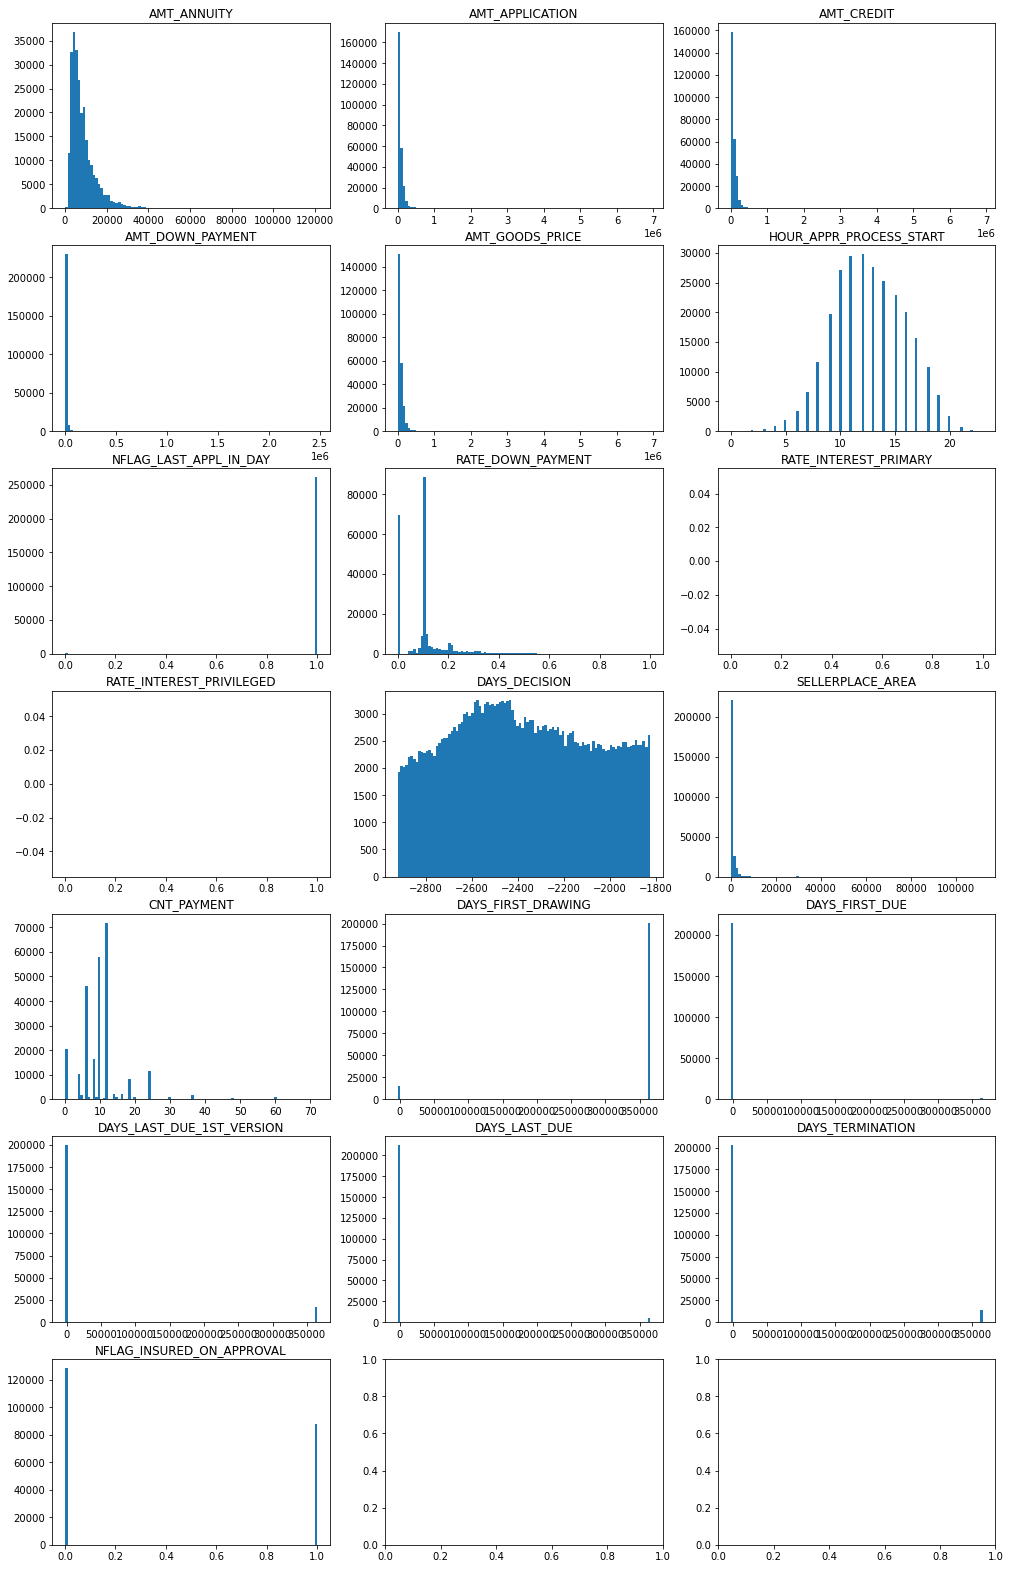

In [10]:
num_columns = prev_app.select_dtypes(include=['float64','int64']).columns 
id_features = ['SK_ID_PREV', 'SK_ID_CURR']
num_columns = [i for i in num_columns if i not in id_features]

print("There are %s float features"%(len(num_columns)))
print(num_columns)

num_feature_plots(prev_app, num_columns)

TODO(): Consider removing the charts above. Not much to learn from the visuals.

There are 16 float features
Index(['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON',
       'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY',
       'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE',
       'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION'],
      dtype='object')


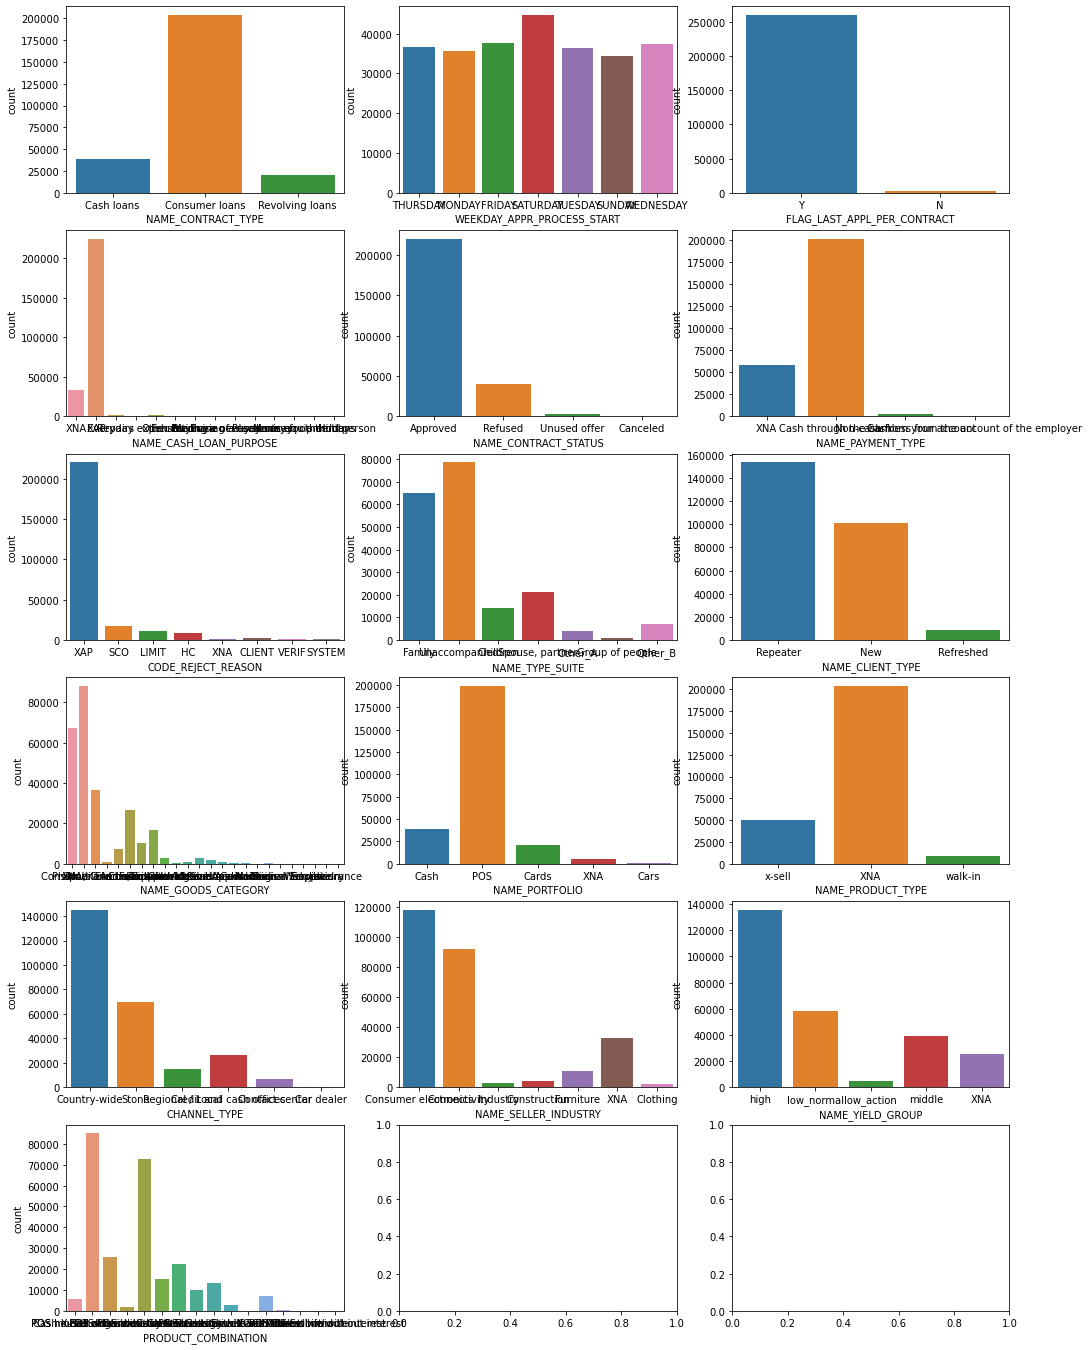

In [29]:
prev_cat_columns = prev_app.select_dtypes(include=['object', 'category']).columns 

print("There are %s float features"%(len(prev_cat_columns)))
print(prev_cat_columns)

categorical_feature_plots(prev_app, prev_cat_columns)

# Bureau

In [30]:
bureau.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,465444.0000,277979.4096,102971.9787,100001.0000,188384.7500,278200.0000,367061.0000,456253.0000
SK_ID_BUREAU,465444.0000,5849441.8498,516999.9314,658069.0000,5262329.7500,5844750.5000,6311759.2500,6837603.0000
DAYS_CREDIT,465443.0000,-1138.2586,792.3926,-2922.0000,-1659.0000,-984.0000,-473.0000,0.0000
CREDIT_DAY_OVERDUE,465443.0000,0.7521,34.5401,0.0000,0.0000,0.0000,0.0000,2765.0000
DAYS_CREDIT_ENDDATE,436502.0000,526.2702,5007.1786,-41879.0000,-1125.0000,-320.0000,486.0000,31198.0000
DAYS_ENDDATE_FACT,293310.0000,-1011.2866,714.4851,-42023.0000,-1479.0000,-891.0000,-421.0000,0.0000
AMT_CREDIT_MAX_OVERDUE,157523.0000,3518.5611,61503.9493,0.0000,0.0000,0.0000,0.0000,11246044.5000
CNT_CREDIT_PROLONG,465443.0000,0.0062,0.0938,0.0000,0.0000,0.0000,0.0000,5.0000
AMT_CREDIT_SUM,465441.0000,355623.7088,916928.1492,0.0000,52411.5000,127978.2450,315000.0000,103500000.0000
AMT_CREDIT_SUM_DEBT,395326.0000,138922.9153,651658.5087,-4705600.3200,0.0000,0.0000,43141.5000,47406861.0000


TypeError: 'AxesSubplot' object is not subscriptable

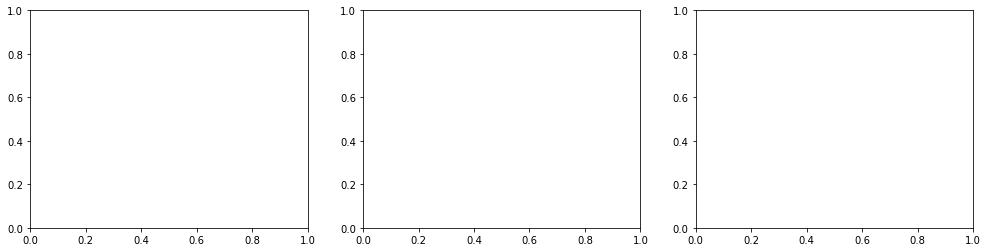

In [31]:
b_cat_columns = bureau.select_dtypes(include=['object']).columns 

total_rows, total_cols, fig_width, fig_height = multiplot_args(bureau,b_cat_columns)
categorical_feature_plots(bureau, b_cat_columns)


Only 1 currency, most are credit closed and there are many credit types.

In [ ]:
bureau.CREDIT_TYPE.value_counts()

There are 12 float features
['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY']


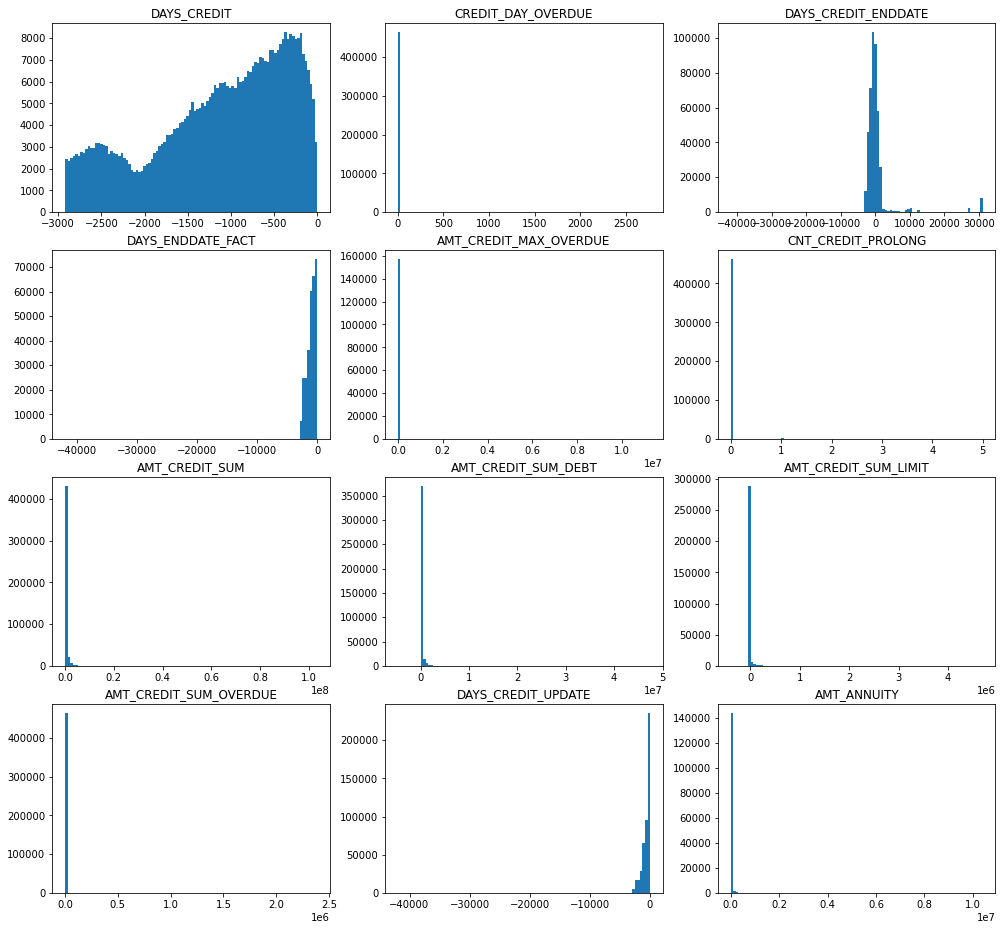

In [32]:
b_num_columns = bureau.select_dtypes(include=['float64','int64']).columns 
id_features = ['SK_ID_PREV', 'SK_ID_CURR', 'SK_ID_BUREAU']
b_num_columns = [i for i in b_num_columns if i not in id_features]

print("There are %s float features"%(len(b_num_columns)))
print(b_num_columns)

num_feature_plots(bureau, b_num_columns)

### Correlations

In [33]:
# Look at Correlations w/ TARGET
bureau = pd.merge(bureau, df[['SK_ID_CURR','TARGET']], on=['SK_ID_CURR'])
bureau.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,381049.0000,278270.7670,102985.4844,100004.0000,188763.0000,278665.0000,367395.0000,456253.0000
SK_ID_BUREAU,381049.0000,5808346.7097,516964.2786,658069.0000,5248261.0000,5805190.0000,6257759.0000,6837603.0000
DAYS_CREDIT,381048.0000,-1141.8706,799.1627,-2922.0000,-1668.0000,-984.0000,-469.0000,0.0000
CREDIT_DAY_OVERDUE,381048.0000,0.8516,36.8977,0.0000,0.0000,0.0000,0.0000,2765.0000
DAYS_CREDIT_ENDDATE,357474.0000,498.8538,4957.3980,-41879.0000,-1137.0000,-327.0000,484.0000,31198.0000
DAYS_ENDDATE_FACT,239100.0000,-1019.4236,720.6352,-42023.0000,-1498.0000,-897.0000,-425.0000,0.0000
AMT_CREDIT_MAX_OVERDUE,133122.0000,3620.6505,63283.2846,0.0000,0.0000,0.0000,0.0000,11246044.5000
CNT_CREDIT_PROLONG,381048.0000,0.0073,0.1018,0.0000,0.0000,0.0000,0.0000,5.0000
AMT_CREDIT_SUM,381046.0000,352009.4422,914813.8681,0.0000,52240.5000,127004.9400,315000.0000,103500000.0000
AMT_CREDIT_SUM_DEBT,322095.0000,137602.4188,648305.0327,-4705600.3200,0.0000,0.0000,42642.0000,43094443.5000


In [34]:
total_credit = pd.pivot_table(bureau, index = ('SK_ID_CURR'), 
                              values = ('AMT_CREDIT_SUM', 'TARGET'))
# bureau.groupby('SK_ID_CURR')
total_credit.corr()

,AMT_CREDIT_SUM,TARGET
AMT_CREDIT_SUM,1.0000,-0.0209
TARGET,-0.0209,1.0000


In [35]:
correlations = bureau.corr()['TARGET'].sort_values(ascending=False)
correlations

TARGET                    1.0000
DAYS_CREDIT               0.0628
DAYS_ENDDATE_FACT         0.0425
DAYS_CREDIT_UPDATE        0.0398
DAYS_CREDIT_ENDDATE       0.0251
AMT_CREDIT_SUM_OVERDUE    0.0083
AMT_CREDIT_MAX_OVERDUE    0.0043
AMT_CREDIT_SUM_DEBT       0.0031
CREDIT_DAY_OVERDUE        0.0017
SK_ID_CURR                0.0010
CNT_CREDIT_PROLONG        0.0008
AMT_ANNUITY              -0.0015
SK_ID_BUREAU             -0.0082
AMT_CREDIT_SUM_LIMIT     -0.0090
AMT_CREDIT_SUM           -0.0130
Name: TARGET, dtype: float64

# Expand Initial Feature Set

In [ ]:
df_agg = copy.deepcopy(df)


In [ ]:
# Has applicant ever been approved for any product 
prev_app['Approved'] = prev_app.NAME_CONTRACT_STATUS == 'Approved'
ever_approved = pd.DataFrame(prev_app.groupby("SK_ID_CURR")["Approved"].any())
df_agg = df_agg.merge(ever_approved, on = ['SK_ID_CURR'], how = 'left')
df_agg.rename({"Approved":"APPROVED_LOAN_LAST5YEARS"}, axis = 1, inplace = True)
df_agg['APPROVED_LOAN_LAST5YEARS'] = df_agg['APPROVED_LOAN_LAST5YEARS']*1


In [ ]:
credit_hot_code = pd.get_dummies(bureau['CREDIT_ACTIVE'] )
bureau = pd.concat([bureau, credit_hot_code], axis = 1)
bureau.head()

In [ ]:
# for each applicant determine the number of bad debt and active loans 
totals_per = bureau.groupby('SK_ID_CURR').agg({'Active': 'sum', 'Bad debt':'sum', 'AMT_CREDIT_SUM':'sum'})
df_agg = df_agg.merge(totals_per, on = ['SK_ID_CURR'], how = 'left')


In [ ]:
df_agg['APP_CREDIT_INCOME_RATIO'] = df_agg['AMT_CREDIT'] / df_agg['AMT_INCOME_TOTAL']


In [ ]:
df_agg.fillna({x:0 for x in ['Active','Bad debt','AMT_CREDIT_SUM','APP_CREDIT_INCOME_RATIO']}, inplace = True)
